<a href="https://colab.research.google.com/github/DAYSIMAOSS/melhorescompras/blob/main/reconhecimento_facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
# =========================
# CÉLULA 1 - IMPORTAR BIBLIOTECAS
# =========================
import numpy as np
import cv2
import os
from zipfile import ZipFile


In [124]:
# =========================
# CÉLULA 2 - DESCOMPACTAR DATASET.ZIP
# =========================
with ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("/content")

# Verificar extração
print(os.listdir("/content"))

# Definir caminho base do dataset
base_path = "/content/dataset"
print("Caminho do dataset:", base_path)


['.config', 'dataset.zip', '__MACOSX', 'face_recognition_sface_2021dec.onnx', 'dataset', 'face_detection_yunet_2023mar.onnx', 'sample_data']
Caminho do dataset: /content/dataset


In [125]:
# =========================
# CÉLULA 3 - CONFIGURAR DETECTOR DE ROSTOS (YuNet)
# =========================
def config_detection(img):
    nms_threshold = 0.3
    score_threshold = 0.9
    yunet_shape = (img.shape[1], img.shape[0])
    topk = 5000

    detector = cv2.FaceDetectorYN.create(
        "face_detection_yunet_2023mar.onnx",
        "",
        yunet_shape,
        score_threshold,
        nms_threshold,
        topk
    )
    return detector



In [126]:
# =========================
# CÉLULA 4 - CONFIGURAR DETECÇÃO DE ROSTO (AJUSTADA)
# =========================
def config_detection(img):
    # Limites de detecção ajustados para rostos mais difíceis
    score_threshold = 0.6  # antes 0.9
    nms_threshold = 0.3
    top_k = 5000

    # Cria o detector YuNet
    detector = cv2.FaceDetectorYN.create(
        "face_detection_yunet_2023mar.onnx", "",
        (img.shape[1], img.shape[0]),
        score_threshold, nms_threshold, top_k
    )
    return detector



In [127]:
# =========================
# CÉLULA 5 - ALINHAR ROSTO E EXTRACAO DE FEATURES (SFace)
# =========================
def align_and_extract_features(recognizer, img, faces_and_landmarks):
    face_align = recognizer.alignCrop(img, faces_and_landmarks[1][0])
    facial_features = recognizer.feature(face_align)
    return facial_features


In [128]:
# =========================
# CÉLULA 6 - CALCULAR SIMILARIDADE (COSINE E L2)
# =========================
def calculate_similarity(recognizer, features1, features2):
    cosine_score = recognizer.match(features1, features2, cv2.FaceRecognizerSF_FR_COSINE)
    l2_score = recognizer.match(features1, features2, cv2.FaceRecognizerSF_FR_NORM_L2)
    return cosine_score, l2_score


In [129]:
# =========================
# CÉLULA 7 - PROCESSAR IMAGEM (VERSÃO SEGURA OPENCV5)
# =========================
def process_image(path, recognizer):
    img = cv2.imread(path)
    if img is None:
        print(f"Erro ao carregar {path}")
        return None

    detector = config_detection(img)
    detection = detector.detect(img)  # retorna uma tupla

    # Verificar se algo foi detectado
    if detection is None:
        print(f"Nenhum rosto detectado em {path}")
        return None

    faces = detection[1]  # bounding boxes

    if faces is None or len(faces) == 0:
        print(f"Nenhum rosto detectado em {path}")
        return None

    # Extrair features do primeiro rosto detectado
    features = align_and_extract_features(recognizer, img, detection)
    return features


In [130]:
# =========================
# CÉLULA 8 - LOOP PRINCIPAL DE RECONHECIMENTO FACIAL (FINAL)
# =========================

# Criar reconhecedor SFace
recognizer = cv2.FaceRecognizerSF.create("face_recognition_sface_2021dec.onnx", "")

# Limites de similaridade ajustados para reduzir falsos negativos
# Cosine mais próximo de 1 = rostos mais semelhantes
# L2 mais próximo de 0 = rostos mais semelhantes
cosine_threshold = 0.3   # antes era 0.363
l2_threshold = 1.2       # antes era 1.128

# Listar todas as pessoas (somente diretórios)
pessoas = [p for p in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, p))]

# Loop por cada pessoa
for pessoa in pessoas:
    pessoa_path = os.path.join(base_path, pessoa)
    treino_path = os.path.join(pessoa_path, "treino")
    teste_path = os.path.join(pessoa_path, "teste")

    # Pega a imagem de teste (somente arquivos de imagem)
    teste_imgs = [os.path.join(teste_path, f) for f in os.listdir(teste_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not teste_imgs:
        continue
    teste_img = teste_imgs[0]

    # Extrair features do teste
    feature_teste = process_image(teste_img, recognizer)
    if feature_teste is None:
        continue

    print(f"\n🧍 Pessoa: {pessoa}")

    # Comparar com todas as imagens de treino
    treino_imgs = [f for f in os.listdir(treino_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for treino_img in treino_imgs:
        treino_file = os.path.join(treino_path, treino_img)
        feature_treino = process_image(treino_file, recognizer)
        if feature_treino is None:
            continue

        # Calcular similaridade Cosine e L2
        cosine_score, l2_score = calculate_similarity(recognizer, feature_treino, feature_teste)

        # Verificar se são a mesma pessoa
        if (cosine_score >= cosine_threshold) or (l2_score <= l2_threshold):
            resultado = "✅ MESMA PESSOA"
        else:
            resultado = "❌ PESSOAS DIFERENTES"

        # Mostrar resultados
        print(f"Treino: {treino_img} | Cosine: {cosine_score:.3f} | L2: {l2_score:.3f} → {resultado}")



🧍 Pessoa: pessoa2
Treino: p2_2.jpeg | Cosine: 0.593 | L2: 0.903 → ✅ MESMA PESSOA
Treino: p2_3.jpeg | Cosine: 0.530 | L2: 0.970 → ✅ MESMA PESSOA
Treino: p2_4.jpeg | Cosine: 0.576 | L2: 0.921 → ✅ MESMA PESSOA
Treino: P2_1.jpeg | Cosine: 0.574 | L2: 0.923 → ✅ MESMA PESSOA

🧍 Pessoa: pessoa5
Treino: p5_2.jpeg | Cosine: 0.776 | L2: 0.669 → ✅ MESMA PESSOA
Treino: p5_4.jpeg | Cosine: 0.131 | L2: 1.318 → ❌ PESSOAS DIFERENTES
Treino: p5_1.jpeg | Cosine: 0.535 | L2: 0.964 → ✅ MESMA PESSOA
Treino: p5_3.jpeg | Cosine: 0.131 | L2: 1.318 → ❌ PESSOAS DIFERENTES

🧍 Pessoa: passoa4
Treino: p4_3.jpeg | Cosine: 0.723 | L2: 0.744 → ✅ MESMA PESSOA
Treino: p4_2.jpeg | Cosine: 0.783 | L2: 0.659 → ✅ MESMA PESSOA
Treino: p4_1.jpeg | Cosine: 0.804 | L2: 0.627 → ✅ MESMA PESSOA
Treino: p4_4.jpeg | Cosine: 0.716 | L2: 0.754 → ✅ MESMA PESSOA

🧍 Pessoa: pessoa3
Treino: p3_2.jpeg | Cosine: 0.862 | L2: 0.525 → ✅ MESMA PESSOA
Treino: p3_4.jpeg | Cosine: 0.808 | L2: 0.620 → ✅ MESMA PESSOA
Treino: p3_1.jpeg | Cosine: 0.

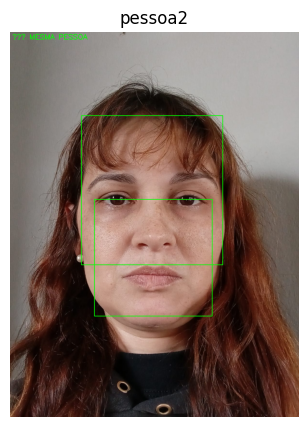

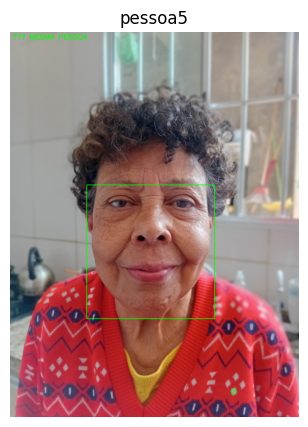

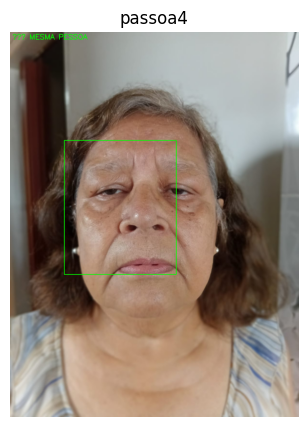

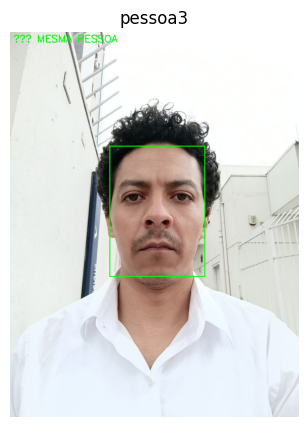

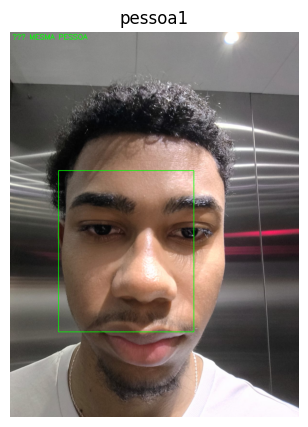

In [131]:
# =========================
# CÉLULA 9 - EXIBIÇÃO DAS IMAGENS DE TESTE DE CADA PESSOA
# =========================
import cv2
import matplotlib.pyplot as plt

# Função para desenhar retângulo e texto na imagem
def draw_face_result(img_path, resultado):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detecta rostos
    detector = cv2.FaceDetectorYN.create(
        "face_detection_yunet_2023mar.onnx", "",
        (img.shape[1], img.shape[0]), 0.6, 0.3, 5000
    )
    faces_and_landmarks = detector.detect(img)

    if faces_and_landmarks is not None and faces_and_landmarks[1] is not None:
        for face in faces_and_landmarks[1]:
            x, y, w, h = face[:4].astype(int)
            cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Adiciona texto
    cv2.putText(img_rgb, resultado, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    return img_rgb

# Percorre todas as pessoas
pessoas = [p for p in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, p))]

for pessoa in pessoas:
    teste_path = os.path.join(base_path, pessoa, "teste")

    # Pega a primeira imagem de teste válida
    teste_imgs = [f for f in os.listdir(teste_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not teste_imgs:
        continue
    teste_img = os.path.join(teste_path, teste_imgs[0])

    # Extrai feature do teste
    feature_teste = process_image(teste_img, recognizer)
    if feature_teste is None:
        resultado = "❌ ROSTO NÃO DETECTADO"
    else:
        # Comparar com todas as imagens de treino para essa pessoa
        treino_path = os.path.join(base_path, pessoa, "treino")
        treino_imgs = [os.path.join(treino_path, f) for f in os.listdir(treino_path)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Vamos comparar com a primeira imagem de treino como referência
        if treino_imgs:
            feature_treino = process_image(treino_imgs[0], recognizer)
            if feature_treino is None:
                resultado = "❌ ROSTO NÃO DETECTADO"
            else:
                cosine_score, l2_score = calculate_similarity(recognizer, feature_treino, feature_teste)
                if (cosine_score >= 0.3) or (l2_score <= 1.2):
                    resultado = "✅ MESMA PESSOA"
                else:
                    resultado = "❌ PESSOAS DIFERENTES"
        else:
            resultado = "❌ SEM IMAGENS DE TREINO"

    # Desenha e mostra
    img_result = draw_face_result(teste_img, resultado)
    plt.figure(figsize=(5,5))
    plt.title(pessoa)
    plt.imshow(img_result)
    plt.axis('off')
    plt.show()

